In [66]:
!pip install tslearn

In [67]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import random
from sklearn.impute import SimpleImputer,KNNImputer
from scipy.stats import boxcox, shapiro, skew
from sklearn.preprocessing import PowerTransformer
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.metrics import dtw
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import silhouette_score
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np















1) Chargement et assemblage des données

In [68]:
df_main=pd.read_csv('clean_data_total.csv', parse_dates=['Date'])
#on a charger la base de donnes tout en covirtissant la colonne Date en datetime

df_janvier_2025 = df_main[(df_main['Date'].dt.year == 2025) & (df_main['Date'].dt.month == 1)]
df_janvier_2025.sort_values(by=['Date','Code prdt']).reset_index(drop=True)
df_janvier_2025

df_janvier_2025.to_csv('df_janvier_2025.csv', index=False)





In [69]:
# 2) Supprimer de df_main toutes les lignes correspondant à Janvier 2025
df_main = df_main[~((df_main['Date'].dt.year == 2025) & (df_main['Date'].dt.month == 1))]

# Vérification rapide
df_main

,Code prdt,DESIGNATION,Classe,Date,month,year,vente,stock,Total,cg,...,pfc,cde,hedelix,respi,gastro,otc,mb,vip,P_valeur,feature
0,PFC005,Ialugyn ovules boite de 10,C,2023-01-01,1,2023,1724,2941,5117,1,...,0,1,0,0,0,0,0,0,0.045409,13247.869828
1,PFC005,Ialugyn ovules boite de 10,C,2023-02-01,2,2023,1572,4105,2566,1,...,0,1,0,0,0,0,0,0,0.045409,2478.993327
2,PFC005,Ialugyn ovules boite de 10,C,2023-03-01,3,2023,1482,3358,2541,1,...,0,1,0,0,0,0,0,0,0.045409,2942.425348
3,PFC005,Ialugyn ovules boite de 10,C,2023-04-01,4,2023,921,3252,1662,1,...,1,1,0,0,0,0,0,0,0.045409,749.848107
4,PFC005,Ialugyn ovules boite de 10,C,2023-05-01,5,2023,2420,3919,2437,1,...,1,1,0,0,0,0,0,0,0.045409,2776.793851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927,PF005,C Lens Solution externe flacon 180 ML,B,2024-08-01,8,2024,0,0,0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2928,PF005,C Lens Solution externe flacon 180 ML,B,2024-09-01,9,2024,0,0,0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2929,PF005,C Lens Solution externe flacon 180 ML,B,2024-10-01,10,2024,347,0,0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2930,PF005,C Lens Solution externe flacon 180 ML,B,2024-11-01,11,2024,0,685,0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000


In [70]:
df_main['year']=df_main['Date'].dt.year
df_main['month']=df_main['Date'].dt.month


In [71]:

df=df_main.sort_values(by=['Date','Code prdt']).reset_index(drop=True)
print(df.shape)
df


(2814, 21)


,Code prdt,DESIGNATION,Classe,Date,month,year,vente,stock,Total,cg,...,pfc,cde,hedelix,respi,gastro,otc,mb,vip,P_valeur,feature
0,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-01-01,1,2023,18480,30675,30508,1,...,0,1,0,0,0,0,0,0,0.776232,40486.117447
1,PF012,"Dermosone 0,05% crème dermique tube 15GR",A0,2023-01-01,1,2023,17909,19819,28417,1,...,0,1,0,0,0,0,0,0,0.205631,31790.044590
2,PF013,"Dermosone 0,05% pomade dermique tube 15GR",A0,2023-01-01,1,2023,31336,34152,42070,1,...,0,1,0,0,0,0,0,0,0.462328,46889.958217
3,PF014,"Fluskin 0,05% gel dermique tube 30GR",B,2023-01-01,1,2023,1645,3247,2600,1,...,0,1,0,0,0,0,0,0,0.313387,3473.936489
4,PF016,"Dermosone Neo 0,05% crème dermique tube 15GR",B,2023-01-01,1,2023,411,86,200,1,...,0,1,0,0,0,0,0,0,0.945152,1225.806452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,PFC048,Vitamine A Plus,C,2024-12-01,12,2024,250,25226,8110,0,...,1,0,0,0,0,0,0,0,0.300622,1859.589668
2810,PFC049,Curbow gélule boite de 30,C,2024-12-01,12,2024,10,2770,667,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2811,PFC050,Till Plus 200ML,B,2024-12-01,12,2024,268,38257,15684,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2812,PFC051,Combimag gélules boite de 30,B,2024-12-01,12,2024,122,7068,1532,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000


2) EXPLORATION DES Donnes (EDA)

In [72]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814 entries, 0 to 2813
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Code prdt    2814 non-null   object        
 1   DESIGNATION  2814 non-null   object        
 2   Classe       2814 non-null   object        
 3   Date         2814 non-null   datetime64[ns]
 4   month        2814 non-null   int32         
 5   year         2814 non-null   int32         
 6   vente        2814 non-null   int64         
 7   stock        2814 non-null   int64         
 8   Total        2814 non-null   int64         
 9   cg           2814 non-null   int64         
 10  ipp          2814 non-null   int64         
 11  pfc          2814 non-null   int64         
 12  cde          2814 non-null   int64         
 13  hedelix      2814 non-null   int64         
 14  respi        2814 non-null   int64         
 15  gastro       2814 non-null   int64         
 16  otc   

Analyse détaillé des colonnes

1. colonne vente: il y a une grande difference entre la mediane et le maximum ce qui suggere la presence des outliers. la moyenne est au dessus de la mediane ce qui prouve que la distribution de la colonne vente est asymetrique (right skewed)

  => on doit faire des transformations pour normaliser les valeurs

2. colonne stock: la mediane est inferieur a la moyenne ce qui seggere que la distribution de colonne stock est asymetrique (right skewed). en plus de ca, il ya presence de valeurs negatives( ce qui n'est pas logique)

  =>il faut trouver une solution pour la gestion des valeurs negatives

3. les colonnes( cg, cde, hedelix,respi, gastro, otc,mb,vip,ipp,pfc): ce sont des variables binaires indique la presence ou l absence d'une caracteristique =>il faut etudier la correlation de ces variables avec la colonne vente

4. la colonne feature: la presence de valeurs negatives tres importantes . en plus il y a une distribution dispersée puisque on a un maximum et ecart-type tres grande =>il faut traiter les valeurs negatives et les outliers

5. la colonne Total: il s agit d' une large dispertion puisque l ecart-type est tres grande(2 fois que le moyenne). en plus de ca la distribution est asymetrique(right skewwed) et il contiennent des valeurs negatives ( qui c est pas logique)

2-1 Distributions de variables

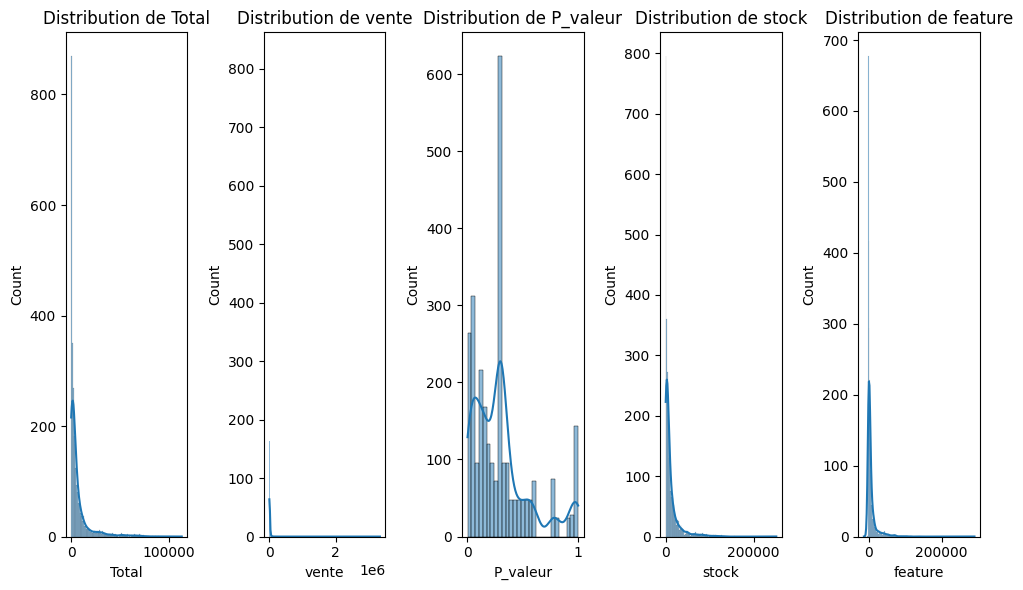

In [73]:


features_to_inspect = ['Total', 'vente','P_valeur', 'stock',  'feature']

fig, ax = plt.subplots(nrows=1, ncols=len(features_to_inspect), figsize=(10, 6))

for i, col in enumerate(features_to_inspect):
    if col in df.columns:
        sns.histplot(data=df[col].dropna(), kde=True, ax=ax[i])
        ax[i].set_title(f'Distribution de {col}')

plt.tight_layout()
plt.show()



Analyse des distributions:

1. colonne Totale: la distribution est fortement asymetrique a (right skeewd).il ya des outliers(dans la queue de distribution).

  =>il faut appliquer une transformation pour stabiliser cette distribution
2. colonne vente: la distribution est fortement asymetrique a droite. la plus part des valeurs sont proches de 0. en plus de ca il ya des valeurs outliers importants

  R.q: certains transactions sont plus importantes que la majorité(medicaments)

  => il faut appliquer des transformations pour que ces valeurs ne biaisent dans le futur

3. la distribution est similaire au distribution de vente et Total , majorites des valeurs sont proches de 0 sans oublier de presence d'outliers.

R.q: certains medicaments ont beacoup de stock que d'autres.on peut conclure ici que il ya des prosuits sont tres demandées que d'autres(liee au vente)

4. la colonne feature a la meme tendance que les autres colonnes mentionnes(asymetrie a droite, beaucoup de valeurs proche de 0 t quelques valeurs tres grandes, presence d outliers)


5. la colonne P_value: c est une distribution multimodale:
  1. P_value proche de zero: la presence de promotion impacte fortement les ventes
  2. P_value proche de 1: la presence de promotion n a pas d impact sur la vente







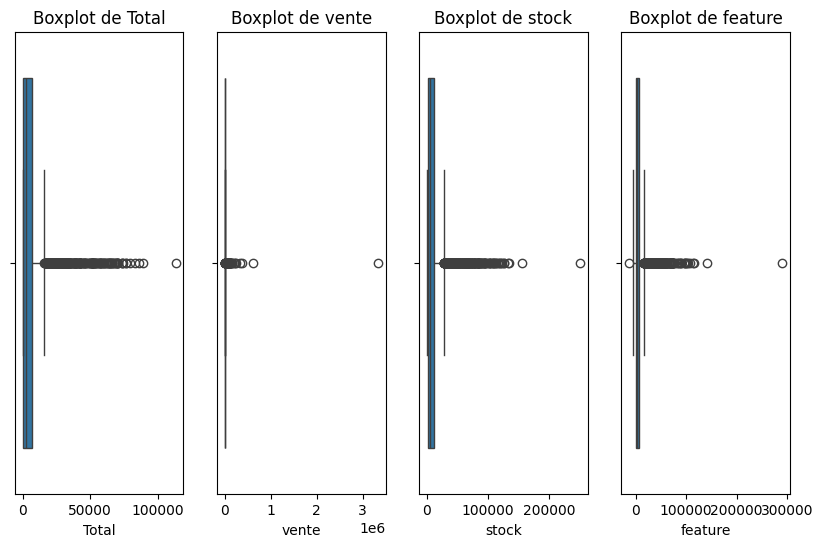

In [74]:
features = ['Total', 'vente', 'stock',  'feature']

fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(10, 6))


for i, col in enumerate(features):

        sns.boxplot(x=df[col].dropna(), ax=ax[i])
        ax[i].set_title(f'Boxplot de {col}')

plt.show()


Analyse des Boxplots:

=>il ya concentration de beucoup de valeurs en dehors de boxplot ce qui signifie que ces variables contiennent plusieurs valeurs extremes ce qui put influencer fortement la moyenne et biaser les analyses

1. Total: forte presence d outliers au dessus de 3eme quartile
  =>la majorite de valeurs est concentre vers les faibles valeurs

2. Vente:pratiquement le mem cas de "Total"
  =>il ya petit nombre de medicaments qui realise l esssentiel de vente

3. Stock:il ya large dispertion a vec beaucoup de valeurs abberantes ( outliers)
  =>il ya des medicaments sont stockes en quantites élevés , d'autres faibles

4. Feature: il ya une grande variabilite avec plusieurs valeurs abberantes(colonne a etudier)


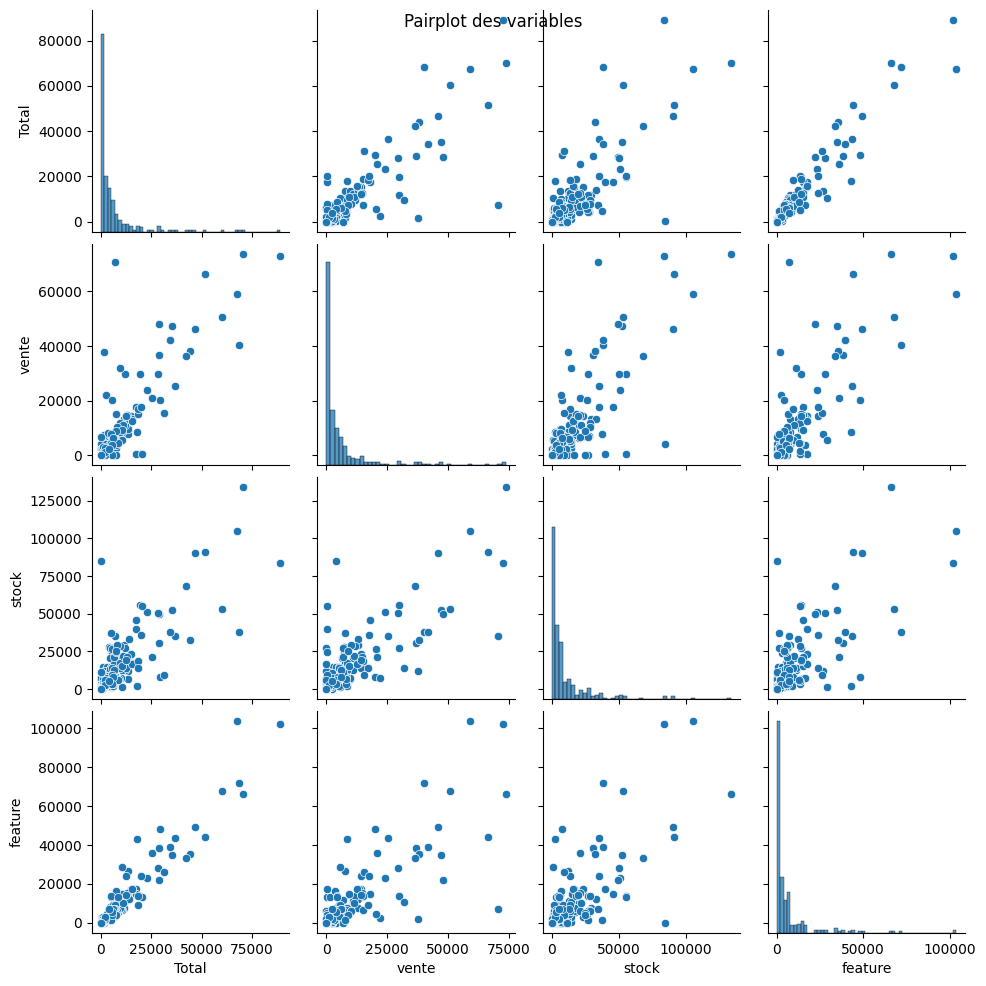

In [75]:
df_sub=df[features].dropna().sample(frac=0.1, random_state=42)
sns.pairplot(df_sub)
plt.suptitle('Pairplot des variables')
plt.show()

Etude des relations

1. Relation entre 'Totale' et 'Vente': il ya une correlation positive forte signifie que les produits  ayant un Total élevé ont une tendance a avoir de fortes ventes

2. RElation entre 'stock' et 'vente':il ya une correlation positive modéré puisque il ya des produits avec un stock élevé ont aussi des ventes élevés,mais pas systematiquement(il y a produits ont un stock élevé mais se vendent un peu)

3. Relation entre 'feature' et 'Total': il ya une correlation tres forte et positive ( c'est normal puisque la colonne "feature" est calculé a partir "Total" des années precedents)

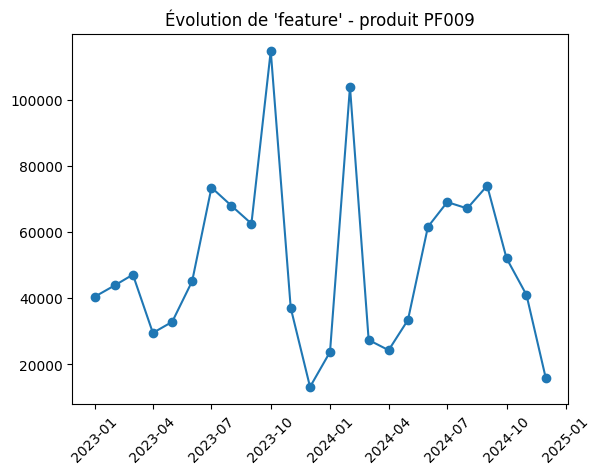

In [76]:
example_product=df["Code prdt"].unique()[0]
df_ex=df[df["Code prdt"]==example_product].sort_values("Date")
plt.figure()
plt.plot(df_ex["Date"],df_ex["feature"],marker='o')
plt.title(f"Évolution de 'feature' - produit {example_product}")
plt.xticks(rotation=45)
plt.show()

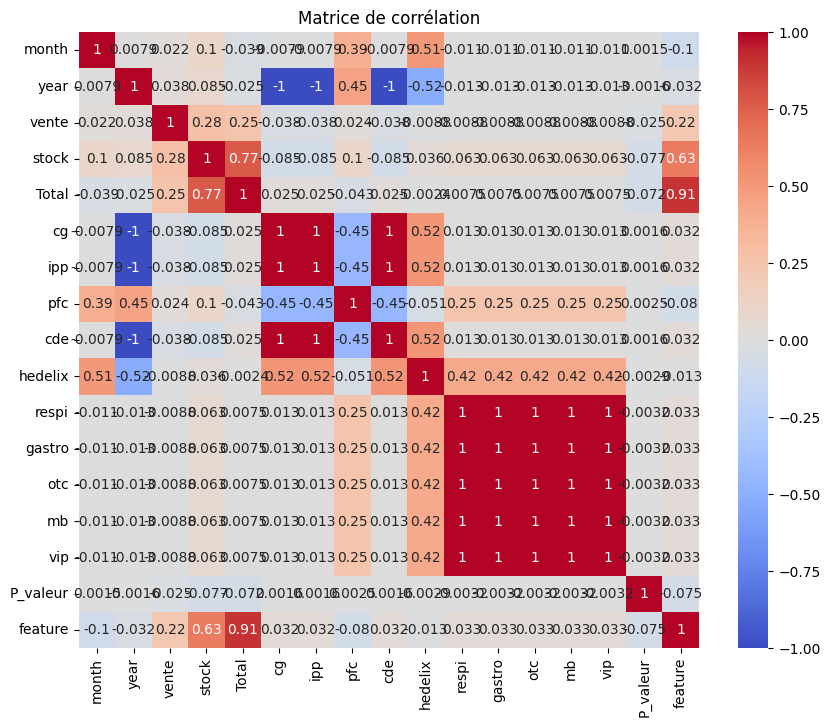

In [77]:
num_cols=df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(),annot=True,cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

Correlation: la matrice de correlation nous permet d'évaluer les relations linéaires entre les variables.


      




3)PRETRAITEMENT

In [78]:
def correct_negative_values(df, cols=["vente", "Total", "stock", "feature"]):
    for col in cols:

        df.loc[df[col] < 0, col] = np.nan
correct_negative_values(df)

In [79]:
df_valid=df[(df["year"]==2024)&(df["month"]==12)]

In [80]:
missing_counts=df[features_to_inspect].isnull().sum()
print("Nb de NaN sur les colonnes principales :\n", missing_counts)

Nb de NaN sur les colonnes principales :
 Total        5
vente       10
P_valeur     0
stock       32
feature     38
dtype: int64


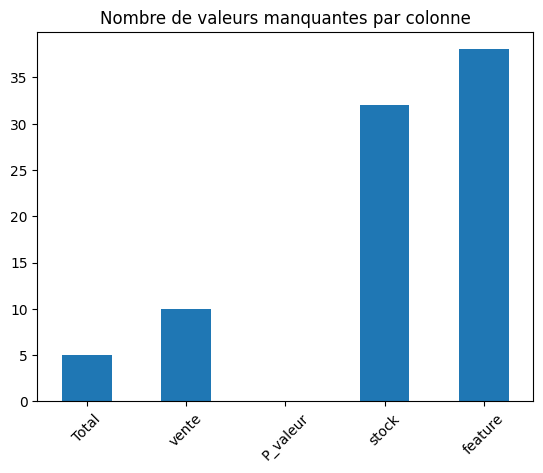

In [81]:
df_focus=df[features_to_inspect]
plt.figure()
df_focus.isnull().sum().plot(kind='bar')
plt.title("Nombre de valeurs manquantes par colonne")
plt.xticks(rotation=45)
plt.show()






Documentation De l'Approche de Selection des Priduits Significatifs


1. Taux de valeurs manquantes par produit
  =>on va calculer les valeurs manquants pour chaque produit

2. nombre minimal de mois de donnes

  => chaque produit doit avoir un historique (un nombre minimum de mois )

3. valeur mensuelle trop faible (pour la colonne Total)

4. Persistance temporelle
  => il concerne la continute de la série (un produit acheté d une facon discontinu(avec de longs trous sans achat) pose un probleme)

5. le coefficient de variation:
  =>elle mesure la dispertion relative des achats mensuelles d'un produit

6. Autocorrélation et caractére aléatoire de la serie

  => une serie sans autocorrelation significative se comporte essentiellment comme de bruit aleatoire

In [82]:

max_missing_rate = 0.1
min_months_required = 20
min_avg_sales = 50.0
cv_threshold = None
max_gap_allowed = 2

min_date = df['Date'].min()
max_date = df['Date'].max()
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1
prod_groups = df.groupby('Code prdt')

months_count = prod_groups['Date'].count()

missing_rate = 1 - (months_count / total_months)

missing_rate_threshold = max_missing_rate


months_threshold = min_months_required

avg_sales = prod_groups['Total'].mean()
avg_sales_threshold = min_avg_sales


std_sales = prod_groups['Total'].std(ddof=0)
cv = std_sales / avg_sales.replace(0, np.nan)  # évite division par zéro
# Seuil du CV via IQR (si non fixé manuellement)
cv_values = cv.dropna()  # ignore les cas indéfinis (moyenne zéro)
Q1_cv, Q3_cv = np.percentile(cv_values, [25, 75])
IQR_cv = Q3_cv - Q1_cv
iqr_cv_threshold = Q3_cv + 1.5 * IQR_cv
cv_threshold = cv_threshold or iqr_cv_threshold

# 5. Détection des interruptions (gaps) dans chaque série
def max_gap_months(date_series):
    """Calcule le plus grand intervalle (en mois) sans données entre deux dates successives."""
    dates = sorted(date_series)
    max_gap = 0
    for i in range(1, len(dates)):
        prev, curr = dates[i-1], dates[i]
        # écart en mois entre deux dates consécutives - 1 (pour avoir les mois *manquants* entre elles)
        gap = (curr.year - prev.year) * 12 + (curr.month - prev.month) - 1
        if gap > max_gap:
            max_gap = gap
    return max_gap

max_gap = prod_groups['Date'].apply(max_gap_months)
max_gap_threshold = max_gap_allowed





valid_products = []
for product in df['Code prdt'].unique():

    if missing_rate[product] > missing_rate_threshold:
        continue

    if months_count[product] < months_threshold:
        continue

    if avg_sales[product] < avg_sales_threshold:
        continue

    if not np.isnan(cv[product]) and cv[product] > cv_threshold:
        continue

    if max_gap[product] > max_gap_threshold:
        continue



    valid_products.append(product)


filtered_df = df[df['Code prdt'].isin(valid_products)].copy()
print(f"Produits conservés : {len(valid_products)} / {df['Code prdt'].nunique()} (soit ~{100*len(valid_products)/df['Code prdt'].nunique():.1f}%)")



Produits conservés : 95 / 125 (soit ~76.0%)


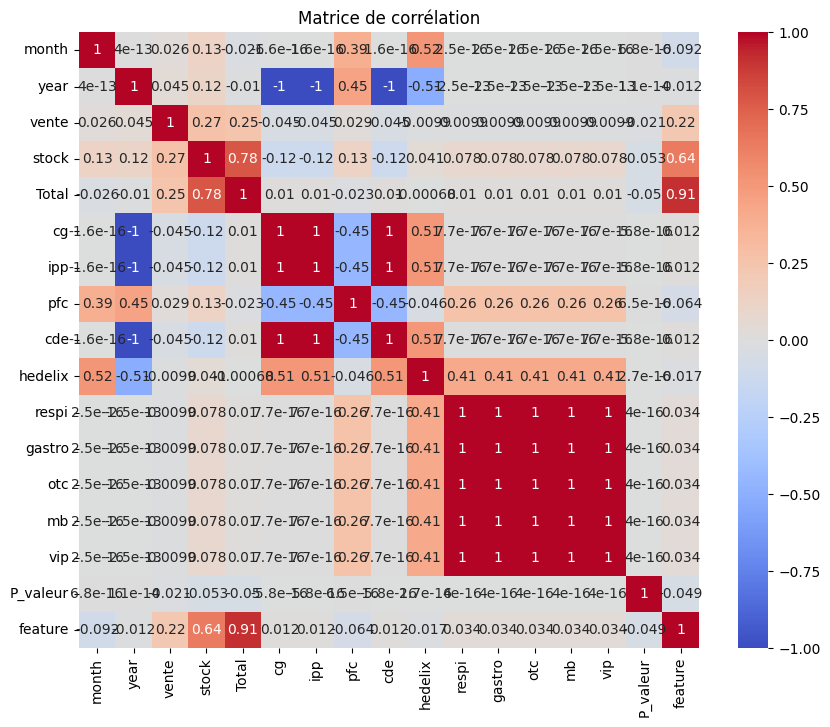

In [83]:
num_cols=filtered_df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(filtered_df[num_cols].corr(),annot=True,cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

In [84]:
filtered_df.isnull().sum()

,0
Code prdt,0
DESIGNATION,0
Classe,0
Date,0
month,0
year,0
vente,2
stock,17
Total,4
cg,0


In [85]:
# Liste des colonnes à traiter
columns_to_impute = ['feature', 'vente', 'stock', 'Total']

# Itérer sur chaque colonne à imputer
for col in columns_to_impute:
    print(f"\nImputation pour la colonne: {col}")

    df_ex_notnull = filtered_df[filtered_df['Code prdt'] == example_product].copy()
    df_ex_notnull = df_ex_notnull[df_ex_notnull[col].notnull()].copy()
    print(f"Avant masquage {col}:", df_ex_notnull.shape)

    if len(df_ex_notnull) > 20:

        np.random.seed(42)
        mask_indices = np.random.choice(df_ex_notnull.index, size=int(0.1 * len(df_ex_notnull)), replace=False)

        true_values = df_ex_notnull.loc[mask_indices, col].copy()
        df_ex_notnull.loc[mask_indices, col] = np.nan

        methods = {}

        # Mean Imputation
        imp_mean = SimpleImputer(strategy='mean')
        df_mean = df_ex_notnull.copy()
        df_mean[col] = imp_mean.fit_transform(df_mean[[col]])
        mae_mean = np.mean(np.abs(df_mean.loc[mask_indices, col] - true_values))
        methods['mean'] = mae_mean

        # Median Imputation
        imp_med = SimpleImputer(strategy='median')
        df_med = df_ex_notnull.copy()
        df_med[col] = imp_med.fit_transform(df_med[[col]])
        mae_med = np.mean(np.abs(df_med.loc[mask_indices, col] - true_values))
        methods['median'] = mae_med

        # KNN Imputation
        imp_knn = KNNImputer(n_neighbors=4)
        df_knn = df_ex_notnull.copy()
        df_knn[col] = imp_knn.fit_transform(df_knn[[col]])
        mae_knn = np.mean(np.abs(df_knn.loc[mask_indices, col] - true_values))
        methods['KNN'] = mae_knn

        # Forward Fill
        df_ffill = df_ex_notnull.copy()
        df_ffill.sort_values(by="Date", inplace=True)  # Ensure the data is sorted
        df_ffill[col] = df_ffill[col].ffill()
        mae_ffill = np.mean(np.abs(df_ffill.loc[mask_indices, col] - true_values))
        methods["ffill"] = mae_ffill

        # Linear Interpolation
        df_lin = df_ex_notnull.copy()
        df_lin.sort_values(by="Date", inplace=True)  # Ensure the data is sorted
        df_lin[col] = df_lin[col].interpolate(method="linear")
        mae_lin = np.mean(np.abs(df_lin.loc[mask_indices, col] - true_values))
        methods["lin"] = mae_lin

        # Print the comparison of methods based on MAE
        print("\nComparaison d'imputation sur sample (", col, ") : MAE\n", methods)

        # Determine the best method based on the lowest MAE
        best_method = min(methods, key=methods.get)
        print(f"Meilleure méthode selon test pour la colonne {col} =", best_method)

    else:
        print(f"\nPas assez de données pour faire une comparaison d'imputation sur {col}.")



Imputation pour la colonne: feature
Avant masquage feature: (24, 21)

Comparaison d'imputation sur sample ( feature ) : MAE
 {'mean': np.float64(14542.798596782504), 'median': np.float64(14542.798596782504), 'KNN': np.float64(14542.798596782504), 'ffill': np.float64(7260.278805947493), 'lin': np.float64(19134.440937067495)}
Meilleure méthode selon test pour la colonne feature = ffill

Imputation pour la colonne: vente
Avant masquage vente: (24, 21)

Comparaison d'imputation sur sample ( vente ) : MAE
 {'mean': np.float64(13766.0), 'median': np.float64(13766.0), 'KNN': np.float64(13766.0), 'ffill': np.float64(10583.0), 'lin': np.float64(8981.5)}
Meilleure méthode selon test pour la colonne vente = lin

Imputation pour la colonne: stock
Avant masquage stock: (24, 21)

Comparaison d'imputation sur sample ( stock ) : MAE
 {'mean': np.float64(17159.045454545456), 'median': np.float64(14219.0), 'KNN': np.float64(17159.045454545456), 'ffill': np.float64(19447.5), 'lin': np.float64(10405.0)}


In [86]:
best_methods = {
    'feature': 'ffill',
    'vente': 'lin',
    'stock': 'lin',
    'Total': 'mean'
}

# Si vos imputations par ffill et interpolation nécessitent que les données soient ordonnées,
# triez le DataFrame par date une seule fois.
filtered_df = filtered_df.sort_values(by="Date")

# Application des méthodes d'imputation choisies
for col, method in best_methods.items():
    print(f"Application de l'imputation '{method}' pour la colonne '{col}'")

    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
        filtered_df[col] = imp.fit_transform(filtered_df[[col]])


    elif method == 'ffill':
        filtered_df[col] = filtered_df[col].ffill()

    elif method == 'lin':
        filtered_df[col] = filtered_df[col].interpolate(method='linear')

Application de l'imputation 'ffill' pour la colonne 'feature'
Application de l'imputation 'lin' pour la colonne 'vente'
Application de l'imputation 'lin' pour la colonne 'stock'
Application de l'imputation 'mean' pour la colonne 'Total'


In [87]:
filtered_df=filtered_df.sort_values(by=['Date','Code prdt']).reset_index(drop=True)

In [88]:


# Fonction pour évaluer l'IQR
def evaluate_iqr(df, col, multipliers):
    results = {}
    n_total = df.shape[0]
    for multiplier in multipliers:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        removed_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        results[multiplier] = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "n_removed": removed_count,
            "percent_removed": 100 * removed_count / n_total
        }
    return results

# Fonction pour évaluer la méthode Winsorize
def evaluate_winsorize(series, limits_list):
    results = {}
    n_total = len(series)

    for lim in limits_list:
        wins = winsorize(series, limits=(lim, lim))
        changed = np.sum(series != wins.data)
        results[lim] = {
            "n_changed": changed,
            "percent_changed": 100 * changed / n_total
        }
    return results

# Liste des multiplicateurs pour l'IQR
iqr_multipliers = [1.5, 2.0, 2.5]
# Liste des limites pour Winsorize
winsor_limits = [0.01, 0.05, 0.1]



for col in features:
    print(f"\n--- Colonne: {col} ---")

    # Évaluation IQR
    print("Méthode IQR :")
    iqr_results = evaluate_iqr(filtered_df, col, iqr_multipliers)
    for mult, stats in iqr_results.items():
        print(f"  Multiplicateur {mult}: {stats['n_removed']} valeurs retirées ({stats['percent_removed']:.2f}%)")

    # Évaluation Winsorize
    print("Méthode Winsorize :")
    # On retire les NaN pour l'évaluation
    winsor_results = evaluate_winsorize(filtered_df[col].dropna(), winsor_limits)
    for lim, stats in winsor_results.items():
        print(f"  Limite {lim}: {stats['n_changed']} valeurs modifiées ({stats['percent_changed']:.2f}%)")







--- Colonne: Total ---
Méthode IQR :
  Multiplicateur 1.5: 252 valeurs retirées (11.05%)
  Multiplicateur 2.0: 219 valeurs retirées (9.61%)
  Multiplicateur 2.5: 189 valeurs retirées (8.29%)
Méthode Winsorize :
  Limite 0.01: 22 valeurs modifiées (0.96%)
  Limite 0.05: 114 valeurs modifiées (5.00%)
  Limite 0.1: 454 valeurs modifiées (19.91%)

--- Colonne: vente ---
Méthode IQR :
  Multiplicateur 1.5: 244 valeurs retirées (10.70%)
  Multiplicateur 2.0: 197 valeurs retirées (8.64%)
  Multiplicateur 2.5: 175 valeurs retirées (7.68%)
Méthode Winsorize :
  Limite 0.01: 22 valeurs modifiées (0.96%)
  Limite 0.05: 228 valeurs modifiées (10.00%)
  Limite 0.1: 456 valeurs modifiées (20.00%)

--- Colonne: stock ---
Méthode IQR :
  Multiplicateur 1.5: 226 valeurs retirées (9.91%)
  Multiplicateur 2.0: 186 valeurs retirées (8.16%)
  Multiplicateur 2.5: 160 valeurs retirées (7.02%)
Méthode Winsorize :
  Limite 0.01: 22 valeurs modifiées (0.96%)
  Limite 0.05: 228 valeurs modifiées (10.00%)
  Limi

In [89]:
filtered_df.to_csv('filtered_df.csv', index=False)

In [90]:

grouped = filtered_df.groupby("Code prdt")


# Méthode IQR
def outliers_iqr(series, k=2.0):

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    filtered = series[(series >= lower_bound) & (series <= upper_bound)]
    return filtered, lower_bound, upper_bound

# Méthode Winsorize
def outliers_winsorize(series, limits=(0.05, 0.05)):

    wins_series = winsorize(series, limits=limits)
    wins_series = pd.Series(wins_series, index=series.index)
    return wins_series

# Méthode 3σ (avec transformation si nécessaire)
def outliers_3sigma(series):

    stat, p_value = shapiro(series)

    if p_value < 0.05:

        transformer = PowerTransformer(method='yeo-johnson', standardize=False)

        series_values = series.values.reshape(-1, 1)
        transformed = transformer.fit_transform(series_values).flatten()

        mu = np.mean(transformed)
        sigma = np.std(transformed)
        lower_bound = mu - 3 * sigma
        upper_bound = mu + 3 * sigma


        mask = (transformed >= lower_bound) & (transformed <= upper_bound)
        filtered_transformed = transformed[mask]
        indices = series.index[mask]


        filtered_original = transformer.inverse_transform(filtered_transformed.reshape(-1, 1)).flatten()
        filtered_series = pd.Series(filtered_original, index=indices)

        return filtered_series, lower_bound, upper_bound, transformer, True
    else:

        mu = series.mean()
        sigma = series.std()
        lower_bound = mu - 3 * sigma
        upper_bound = mu + 3 * sigma

        filtered = series[(series >= lower_bound) & (series <= upper_bound)]
        return filtered, lower_bound, upper_bound, None, False


def evaluate_method(series, method_func, method_name, **kwargs):

    original_len = len(series)

    if method_name == "winsorize":
        filtered = method_func(series, **kwargs)

        changed = np.sum(series != filtered)
        percent_removed = 0
    else:
        filtered, lb, ub, *rest = method_func(series, **kwargs)
        filtered = filtered.dropna()
        percent_removed = 100 * (original_len - len(filtered)) / original_len


    try:
        stat, p_val = shapiro(filtered)
    except Exception as e:
        p_val = np.nan

    skw = skew(filtered)
    return filtered, percent_removed, p_val, skw


def compute_score(p_val, percent_removed):
    percent_kept = 100 - percent_removed
    score = p_val * (percent_kept / 100)
    return score

columns_of_interest = ["Total", "stock", "feature", "vente"]

results_summary = {}

for prod, group in grouped:

    group = group.sort_values("Date")


    results_summary[prod] = {}

    for col in columns_of_interest:
        series = group[col].dropna()


        if len(series) < 10:

            results_summary[prod][col] = {
                "IQR": None,
                "Winsorize": None,
                "3sigma": None,
                "Best_method": None
            }
            continue


        filtered_iqr, perc_iqr, p_iqr, skew_iqr = evaluate_method(series, outliers_iqr, "iqr", k=2.0)
        score_iqr = compute_score(p_iqr, perc_iqr)


        filtered_wins, perc_wins, p_wins, skew_wins = evaluate_method(series, outliers_winsorize, "winsorize", limits=(0.05, 0.05))
        score_wins = compute_score(p_wins, perc_wins)


        filtered_3sigma, perc_3sigma, p_3sigma, skew_3sigma = evaluate_method(series, outliers_3sigma, "3sigma")
        score_3sigma = compute_score(p_3sigma, perc_3sigma)


        scores = {
            "IQR": score_iqr,
            "Winsorize": score_wins,
            "3sigma": score_3sigma
        }
        best_method = max(scores, key=scores.get)


        results_summary[prod][col] = {
            "IQR": {
                "percent_removed": perc_iqr,
                "p_value": p_iqr,
                "skew": skew_iqr,
                "score": score_iqr
            },
            "Winsorize": {
                "percent_removed": perc_wins,
                "p_value": p_wins,
                "skew": skew_wins,
                "score": score_wins
            },
            "3sigma": {
                "percent_removed": perc_3sigma,
                "p_value": p_3sigma,
                "skew": skew_3sigma,
                "score": score_3sigma
            },
            "Best_method": best_method
        }





print("Résumé des meilleures méthodes par produit et par colonne :\n")
for prod, col_dict in results_summary.items():
    print(f"Produit {prod} :")
    for col, methods_info in col_dict.items():
        best = methods_info["Best_method"]
        print(f"  - Colonne {col} -> Meilleure méthode : {best}")
    print("-"*50)




Résumé des meilleures méthodes par produit et par colonne :

Produit PF009 :
  - Colonne Total -> Meilleure méthode : Winsorize
  - Colonne stock -> Meilleure méthode : IQR
  - Colonne feature -> Meilleure méthode : IQR
  - Colonne vente -> Meilleure méthode : IQR
--------------------------------------------------
Produit PF012 :
  - Colonne Total -> Meilleure méthode : IQR
  - Colonne stock -> Meilleure méthode : IQR
  - Colonne feature -> Meilleure méthode : IQR
  - Colonne vente -> Meilleure méthode : IQR
--------------------------------------------------
Produit PF013 :
  - Colonne Total -> Meilleure méthode : IQR
  - Colonne stock -> Meilleure méthode : 3sigma
  - Colonne feature -> Meilleure méthode : IQR
  - Colonne vente -> Meilleure méthode : IQR
--------------------------------------------------
Produit PF014 :
  - Colonne Total -> Meilleure méthode : 3sigma
  - Colonne stock -> Meilleure méthode : IQR
  - Colonne feature -> Meilleure méthode : IQR
  - Colonne vente -> Meille

In [91]:
filtered_df.shape

(2280, 21)

In [92]:
def find_best_methods_for_df(df, groupby_col="Code prdt", columns_of_interest=None):
    if columns_of_interest is None:
        columns_of_interest = ["Total", "stock", "feature", "vente"]

    grouped = df.groupby(groupby_col)
    results_summary = {}

    for prod, group in grouped:

        group = group.sort_values("Date")

        results_summary[prod] = {}

        for col in columns_of_interest:
            series = group[col].dropna()


            if len(series) < 10:
                results_summary[prod][col] = {
                    "IQR": None,
                    "Winsorize": None,
                    "3sigma": None,
                    "Best_method": None
                }
                continue

            # 1) IQR
            filtered_iqr, perc_iqr, p_iqr, skew_iqr = evaluate_method(series, outliers_iqr, "iqr", k=2.0)
            score_iqr = compute_score(p_iqr, perc_iqr)

            # 2) Winsorize
            filtered_wins, perc_wins, p_wins, skew_wins = evaluate_method(series, outliers_winsorize, "winsorize", limits=(0.05, 0.05))
            score_wins = compute_score(p_wins, perc_wins)

            # 3) 3σ
            filtered_3s, perc_3s, p_3s, skew_3s = evaluate_method(series, outliers_3sigma, "3sigma")
            score_3s = compute_score(p_3s, perc_3s)

            scores = {
                "IQR": score_iqr,
                "Winsorize": score_wins,
                "3sigma": score_3s
            }
            best_method = max(scores, key=scores.get)

            results_summary[prod][col] = {
                "IQR": {
                    "percent_removed": perc_iqr,
                    "p_value": p_iqr,
                    "skew": skew_iqr,
                    "score": score_iqr
                },
                "Winsorize": {
                    "percent_removed": perc_wins,
                    "p_value": p_wins,
                    "skew": skew_wins,
                    "score": score_wins
                },
                "3sigma": {
                    "percent_removed": perc_3s,
                    "p_value": p_3s,
                    "skew": skew_3s,
                    "score": score_3s
                },
                "Best_method": best_method
            }

    return results_summary

def apply_best_methods(df, results_summary, groupby_col="Code prdt", columns_of_interest=None):


    if columns_of_interest is None:
        columns_of_interest = ["Total", "stock", "feature", "vente"]

    df_clean = []
    grouped = df.groupby(groupby_col)

    for prod, group in grouped:
        group = group.sort_values("Date")

        group_clean = group.copy()

        outliers_to_remove = set()

        if prod not in results_summary:

            df_clean.append(group_clean)
            continue

        for col in columns_of_interest:
            if col not in results_summary[prod]:

                continue

            best_method = results_summary[prod][col]["Best_method"]
            if best_method is None:
                continue
            if best_method == "Winsorize":

                col_series = group_clean[col].dropna()
                wins_series = outliers_winsorize(col_series, limits=(0.05, 0.05))
                group_clean.loc[wins_series.index, col] = wins_series

            elif best_method == "IQR":

                col_series = group_clean[col].dropna()
                filtered, lb, ub = outliers_iqr(col_series, k=2.0)

                outlier_idx = col_series.index.difference(filtered.index)
                outliers_to_remove.update(outlier_idx)

            elif best_method == "3sigma":
                col_series = group_clean[col].dropna()
                filtered_3s, lb, ub, transformer, used_transform = outliers_3sigma(col_series)

                outlier_idx = col_series.index.difference(filtered_3s.index)
                outliers_to_remove.update(outlier_idx)

        group_clean = group_clean.drop(index=outliers_to_remove)

        df_clean.append(group_clean)


    df_final = pd.concat(df_clean, axis=0)

    df_final = df_final.sort_values([groupby_col, "Date"])
    return df_final
columns_of_interest = ["Total", "stock", "feature", "vente"]
results_summary = find_best_methods_for_df(
    filtered_df,
    groupby_col="Code prdt",
    columns_of_interest=columns_of_interest
)


df_cleaned = apply_best_methods(
    filtered_df,
    results_summary,
    groupby_col="Code prdt",
    columns_of_interest=columns_of_interest
)

df55=apply_best_methods(
    filtered_df,
    results_summary,
    groupby_col="Code prdt",
    columns_of_interest=columns_of_interest
)




In [93]:
df_cleaned.shape

(2033, 21)

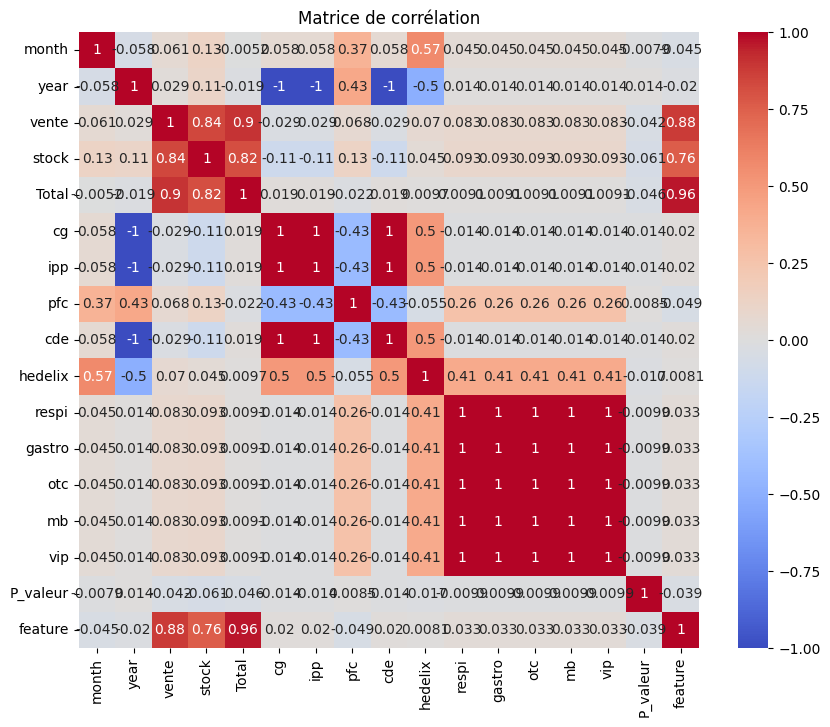

In [94]:
num_cols=df55.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(df55[num_cols].corr(),annot=True,cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

3) Feature engeneering




In [95]:
# Lags pour 1 mois et 2 mois
df_cleaned['vente_lag1'] = df_cleaned.groupby('Code prdt')['vente'].shift(1)
df_cleaned['vente_lag2'] = df_cleaned.groupby('Code prdt')['vente'].shift(2)

df_cleaned['stock_lag1'] = df_cleaned.groupby('Code prdt')['stock'].shift(1)
df_cleaned['stock_lag2'] = df_cleaned.groupby('Code prdt')['stock'].shift(2)

df_cleaned['total_lag1'] = df_cleaned.groupby('Code prdt')['Total'].shift(1)
df_cleaned['total_lag2'] = df_cleaned.groupby('Code prdt')['Total'].shift(2)
df_cleaned['feature_lag1'] = df_cleaned.groupby('Code prdt')['feature'].shift(1)
df_cleaned['feature_lag2'] = df_cleaned.groupby('Code prdt')['feature'].shift(2)



=> les lags sont des variables representant la valeur décalée dans le temps d' une autre variable . il est necessaire pour introduire une mémoire de passé

In [96]:
# Moyenne glissante (3 mois) (puisque notre frequence prédiction est mensuelle)
df_cleaned['vente_roll3'] = df_cleaned.groupby('Code prdt')['vente'].transform(lambda s: s.shift(1).rolling(window=3, min_periods=1).mean())
df_cleaned['stock_roll3'] = df_cleaned.groupby('Code prdt')['stock'].transform(lambda s: s.shift(1).rolling(window=3, min_periods=1).mean())
df_cleaned['total_roll3'] = df_cleaned.groupby('Code prdt')['Total'].transform(lambda s: s.shift(1).rolling(window=3, min_periods=1).mean())
df_cleaned['feature_roll3'] = df_cleaned.groupby('Code prdt')['feature'].transform(lambda s: s.shift(1).rolling(window=3, min_periods=1).mean())


les fenetres glissants (rolling window) nous permet de capturer les tendances locales a travers le calcul une statistique comme la moyenne

In [97]:
# Encodage cyclique pour le mois
df_cleaned['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df_cleaned['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

les variables temporelles cycliques necessitent un encodage special pour etre compris par les model et ici notre cas exceptionnel c'est le mois 12 (decembere)et 1 (janvier) qui sont proche dans le cycle annuel, mais le model  compare 12 par rapport a 1 (comme des numeros brutes) . donc pour respecter la nature cyclique , on transfome le mois en 2 composantes trigonomitriques (cos et sin)


In [98]:

df_cleaned['vente_trend'] = np.nan
df_cleaned['vente_season'] = np.nan
df_cleaned['stock_trend'] = np.nan
df_cleaned['stock_season'] = np.nan
df_cleaned['total_trend'] = np.nan
df_cleaned['total_season'] = np.nan
df_cleaned['feature_trend']=np.nan
df_cleaned['feature_season']=np.nan


# Application de STL pour chaque produit
for prod, group in df_cleaned.groupby('Code prdt'):

    groupe_ordre = group.sort_values('Date')
    # On définit la période pour STL (ici 12 pour une saisonnalité annuelle)
    period = 12
    stl_vente = STL(groupe_ordre['vente'], period=period, robust=True).fit()
    stl_stock = STL(groupe_ordre['stock'], period=period, robust=True).fit()
    stl_total = STL(groupe_ordre['Total'], period=period, robust=True).fit()
    stl_feature = STL(groupe_ordre['feature'], period=period, robust=True).fit()
    df_cleaned.loc[groupe_ordre.index, 'vente_trend'] = stl_vente.trend
    df_cleaned.loc[groupe_ordre.index, 'vente_season'] = stl_vente.seasonal
    df_cleaned.loc[groupe_ordre.index, 'stock_trend'] = stl_stock.trend
    df_cleaned.loc[groupe_ordre.index, 'stock_season'] = stl_stock.seasonal
    df_cleaned.loc[groupe_ordre.index, 'total_trend'] = stl_total.trend
    df_cleaned.loc[groupe_ordre.index, 'total_season'] = stl_total.seasonal
    df_cleaned.loc[groupe_ordre.index, 'feature_trend'] = stl_feature.trend
    df_cleaned.loc[groupe_ordre.index, 'feature_season'] = stl_feature.seasonal



Decompsition STL

=>pour mieux comprendre la structure des séries temporelles, la decomposition STL est benifique ici, il nous permet de connaitre la tendancre(trajectoire a long terme (hausse ou faiblesse)), saisonnalite(une motif qui se repete pour une periode ) et residu(bruit du a des evenements irreguliers)

=> on va maintenant regrouper les series de Total des produits en clusters de formes homogénes
  
  =>ici l'idéé est de detecter les comportements de Total ( par example des produits peuvent avoir un achat saisonniers eleve en ete , d'autre est stable surant l'anneé,)

In [99]:


# Préparation des séries de ventes par produit
series_list = []
product_indices = []  # pour garder l'ordre des produits
for prod, group in df_cleaned.groupby('Code prdt'):

    totals = group.sort_values('Date')['Total'].values
    series_list.append(totals)
    product_indices.append(prod)
X = to_time_series_dataset(series_list)
X_filled = np.nan_to_num(X, nan=0)
# Clustering K-Shape
n_clusters = 3
kshape = KShape(n_clusters=n_clusters, n_init=10, verbose=False, random_state=0)
labels = kshape.fit_predict(X_filled)
# Attribution des labels de cluster à chaque produit
cluster_map = {prod: label for prod, label in zip(product_indices, labels)}
df_cleaned['cluster_label'] = df_cleaned['Code prdt'].map(cluster_map)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [100]:
print(pd.Series(labels).value_counts())

1    60
2    21
0    14
Name: count, dtype: int64


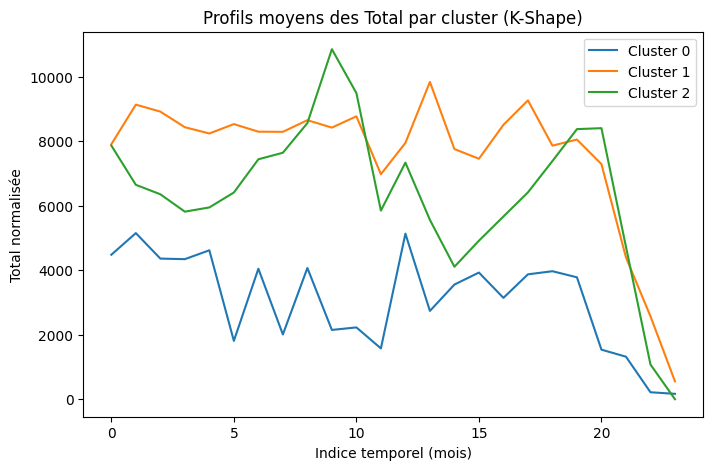

In [101]:
plt.figure(figsize=(8,5))
for cl in range(n_clusters):

    mean_series = np.nanmean(X_filled[labels == cl], axis=0)
    plt.plot(mean_series, label=f'Cluster {cl}')
plt.title("Profils moyens des Total par cluster (K-Shape)")
plt.xlabel("Indice temporel (mois)")
plt.ylabel("Total normalisée")
plt.legend()
plt.show()

Capturer l’accélération ou la décélération des ventes (Total, stocks)
 d’un mois sur l’autre en pourcentage

In [102]:
epsilon = 10e-6
df_cleaned['ratio_stock_vente'] = df_cleaned['stock'] / (df_cleaned['vente'] + epsilon)

Indique le niveau de stock relatif aux ventes. Un ratio élevé peut signaler une sur-stock (ou un stock de sécurité important), tandis qu’un ratio faible peut signaler un stock tendu par rapport aux ventes. Cette information peut être utile pour prédire des comportements futurs (ruptures, ajustements de stock…).

In [103]:
df_cleaned.isnull().sum()

,0
Code prdt,0
DESIGNATION,0
Classe,0
Date,0
month,0
year,0
vente,0
stock,0
Total,0
cg,0


In [104]:
df_cleaned

,Code prdt,DESIGNATION,Classe,Date,month,year,vente,stock,Total,cg,...,vente_trend,vente_season,stock_trend,stock_season,total_trend,total_season,feature_trend,feature_season,cluster_label,ratio_stock_vente
0,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-01-01,1,2023,18480.0,30675.0,30508.0,1,...,23715.670636,18184.472224,39943.879630,-9268.879630,44861.233481,-14353.233481,44691.756571,-4205.639124,2,1.659903
95,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-02-01,2,2023,13324.0,30453.0,28465.0,1,...,25152.658732,-17338.515871,43840.157407,-13387.157407,45145.308136,-16680.308136,44487.063158,-582.848405,2,2.285575
190,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-03-01,3,2023,19854.0,26430.0,33485.0,1,...,26589.646827,-6735.646827,47736.435185,-21306.435185,45429.382791,-21650.070365,44282.369745,2845.686328,2,1.331218
285,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-04-01,4,2023,21239.0,29482.0,33032.0,1,...,28026.634922,-6787.634922,51632.712963,-22150.712963,45713.457446,-6804.145020,44077.676332,-14539.895532,2,1.388107
380,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-05-01,5,2023,31979.0,27309.0,41593.0,1,...,29463.623017,2515.376983,55528.990741,-28219.990741,45997.532101,-4404.532101,43872.982919,-11005.256688,2,0.853967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,PFC045,Hedelix sirop flacon de 120ML,A+,2024-07-01,7,2024,3899.0,34876.0,825.0,0,...,7356.373910,-3457.373910,48222.533758,-13346.533758,6194.451077,-5369.451077,8496.740237,-8280.888521,2,8.944858
1899,PFC045,Hedelix sirop flacon de 120ML,A+,2024-08-01,8,2024,5446.0,46745.0,6180.0,0,...,7349.433930,-1903.433930,47708.991577,-963.991577,6070.317656,109.682344,8971.356750,-464.267130,2,8.583364
1994,PFC045,Hedelix sirop flacon de 120ML,A+,2024-09-01,9,2024,8826.0,48222.0,4241.0,0,...,7342.493951,1483.506049,47195.449396,1026.550604,5946.184235,-1705.184235,9445.973266,-3543.419271,2,5.463630
2089,PFC045,Hedelix sirop flacon de 120ML,A+,2024-10-01,10,2024,17685.0,48069.0,14735.0,0,...,7335.553971,10349.446029,46681.907215,1387.092785,5822.050814,8912.949186,9920.589786,30338.103317,2,2.718066


In [105]:

columns_to_impute = ['vente_lag1','vente_lag2','stock_lag1','stock_lag2','total_lag1','total_lag2','vente_roll3','stock_roll3','total_roll3','feature_lag1','feature_lag2','feature_roll3'

            ]

# Itérer sur chaque colonne à imputer
for col in columns_to_impute:


    df_ex_notnull = df_cleaned[df_cleaned['Code prdt'] == 'PF009'].copy()
    df_ex_notnull = df_ex_notnull[df_ex_notnull[col].notnull()].copy()
    print(f"Avant masquage {col}:", df_ex_notnull.shape)

    if len(df_ex_notnull) > 20:

        np.random.seed(42)
        mask_indices = np.random.choice(df_ex_notnull.index, size=int(0.1 * len(df_ex_notnull)), replace=False)

        true_values = df_ex_notnull.loc[mask_indices, col].copy()
        df_ex_notnull.loc[mask_indices, col] = np.nan

        methods = {}

        # Mean Imputation
        imp_mean = SimpleImputer(strategy='mean')
        df_mean = df_ex_notnull.copy()
        df_mean[col] = imp_mean.fit_transform(df_mean[[col]])
        mae_mean = np.mean(np.abs(df_mean.loc[mask_indices, col] - true_values))
        methods['mean'] = mae_mean

        # Median Imputation
        imp_med = SimpleImputer(strategy='median')
        df_med = df_ex_notnull.copy()
        df_med[col] = imp_med.fit_transform(df_med[[col]])
        mae_med = np.mean(np.abs(df_med.loc[mask_indices, col] - true_values))
        methods['median'] = mae_med

        # KNN Imputation
        imp_knn = KNNImputer(n_neighbors=4)
        df_knn = df_ex_notnull.copy()
        df_knn[col] = imp_knn.fit_transform(df_knn[[col]])
        mae_knn = np.mean(np.abs(df_knn.loc[mask_indices, col] - true_values))
        methods['KNN'] = mae_knn

        # Forward Fill
        df_ffill = df_ex_notnull.copy()
        df_ffill.sort_values(by="Date", inplace=True)  # Ensure the data is sorted
        df_ffill[col] = df_ffill[col].ffill()
        mae_ffill = np.mean(np.abs(df_ffill.loc[mask_indices, col] - true_values))
        methods["ffill"] = mae_ffill

        # Linear Interpolation
        df_lin = df_ex_notnull.copy()
        df_lin.sort_values(by="Date", inplace=True)  # Ensure the data is sorted
        df_lin[col] = df_lin[col].interpolate(method="linear")
        mae_lin = np.mean(np.abs(df_lin.loc[mask_indices, col] - true_values))
        methods["lin"] = mae_lin

        # Print the comparison of methods based on MAE
        print("\nComparaison d'imputation sur sample (", col, ") : MAE\n", methods)

        # Determine the best method based on the lowest MAE
        best_method = min(methods, key=methods.get)
        print(f"Meilleure méthode selon test pour la colonne {col} =", best_method)

    else:
        print(f"\nPas assez de données pour faire une comparaison d'imputation sur {col}.")





Avant masquage vente_lag1: (21, 45)

Comparaison d'imputation sur sample ( vente_lag1 ) : MAE
 {'mean': np.float64(16472.0), 'median': np.float64(16472.0), 'KNN': np.float64(16472.0), 'ffill': np.float64(3111.0), 'lin': np.float64(4225.0)}
Meilleure méthode selon test pour la colonne vente_lag1 = ffill
Avant masquage vente_lag2: (20, 45)

Pas assez de données pour faire une comparaison d'imputation sur vente_lag2.
Avant masquage stock_lag1: (21, 45)

Comparaison d'imputation sur sample ( stock_lag1 ) : MAE
 {'mean': np.float64(25967.65789473684), 'median': np.float64(19541.5), 'KNN': np.float64(25967.65789473684), 'ffill': np.float64(5355.0), 'lin': np.float64(14838.5)}
Meilleure méthode selon test pour la colonne stock_lag1 = ffill
Avant masquage stock_lag2: (20, 45)

Pas assez de données pour faire une comparaison d'imputation sur stock_lag2.
Avant masquage total_lag1: (21, 45)

Comparaison d'imputation sur sample ( total_lag1 ) : MAE
 {'mean': np.float64(14891.5), 'median': np.float

In [106]:
best_methods = {
    'vente_lag2': 'ffill',
    'vente_lag1': 'lin',
    'stock_lag1': 'lin',
    'stock_lag2': 'ffill',
    'total_lag1': 'mean',
    'total_lag2': 'ffill',
    'vente_roll3': 'lin',
    'stock_roll3': 'ffill',
    'total_roll3': 'lin',
    'feature_lag1': 'median',
    'feature_lag2': 'lin',
    'feature_roll3': 'lin'



}




# Application des méthodes d'imputation choisies
for col, method in best_methods.items():
    print(f"Application de l'imputation '{method}' pour la colonne '{col}'")

    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
        df_cleaned[col] = imp.fit_transform(df_cleaned[[col]])


    elif method == 'ffill':
        df_cleaned[col] = df_cleaned[col].ffill()

    elif method == 'lin':
        df_cleaned[col] = df_cleaned[col].interpolate(method='linear')
    elif method == 'median':
        imp = SimpleImputer(strategy='median')
        df_cleaned[col] = imp.fit_transform(df_cleaned[[col]])

Application de l'imputation 'ffill' pour la colonne 'vente_lag2'
Application de l'imputation 'lin' pour la colonne 'vente_lag1'
Application de l'imputation 'lin' pour la colonne 'stock_lag1'
Application de l'imputation 'ffill' pour la colonne 'stock_lag2'
Application de l'imputation 'mean' pour la colonne 'total_lag1'
Application de l'imputation 'ffill' pour la colonne 'total_lag2'
Application de l'imputation 'lin' pour la colonne 'vente_roll3'
Application de l'imputation 'ffill' pour la colonne 'stock_roll3'
Application de l'imputation 'lin' pour la colonne 'total_roll3'
Application de l'imputation 'median' pour la colonne 'feature_lag1'
Application de l'imputation 'lin' pour la colonne 'feature_lag2'
Application de l'imputation 'lin' pour la colonne 'feature_roll3'


In [107]:
df_cleaned.isnull().sum()

,0
Code prdt,0
DESIGNATION,0
Classe,0
Date,0
month,0
year,0
vente,0
stock,0
Total,0
cg,0


In [108]:
for col in ['vente_lag1','vente_lag2','stock_lag1','stock_lag2','total_lag2','vente_roll3','stock_roll3','total_roll3','feature_lag1','feature_lag2','feature_roll3'
            ]:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())

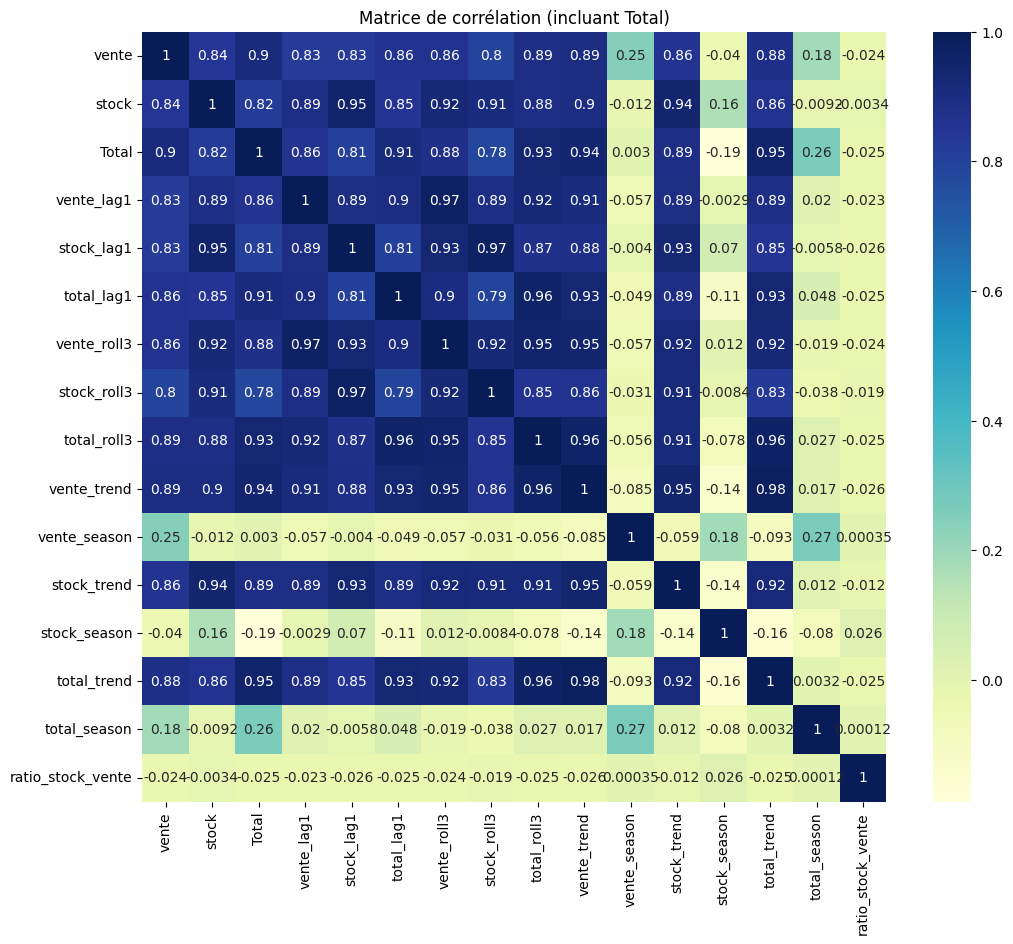

In [109]:
features_corr = [
    'vente','stock','Total',
    'vente_lag1','stock_lag1','total_lag1',
    'vente_roll3','stock_roll3','total_roll3',
    'vente_trend','vente_season','stock_trend','stock_season','total_trend','total_season',
    'ratio_stock_vente',

]

corr_matrix = df_cleaned[features_corr].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title('Matrice de corrélation (incluant Total)')
plt.show()


4)Modelisation

In [110]:
target_col='Total'
excluded_cols = {
    'Date','Total','cg','ipp','pfc','cde','hedelix','respi','gastro','otc','mb','vip','P_valeur',
}

candidate_cols= [c for c in df_cleaned.columns if c not in excluded_cols]
corrs=[]

for c in candidate_cols:
  if pd.api.types.is_numeric_dtype(df_cleaned[c]):
    val=df_cleaned[[c,target_col]]
    corr=val.corr().iloc[0,1]
    corrs.append((c,abs(corr)))
  else:
    corrs.append((c,0.0))

In [111]:
corrs_sorted = sorted(corrs, key=lambda x:x[1], reverse=True)
top_corr = [x[0] for x in corrs_sorted if x[1]> 0]

In [112]:
len(top_corr)

29

In [113]:
df_cleaned2=df_cleaned[(df_cleaned['Date'].dt.year == 2024) & (df_cleaned['Date'].dt.month == 12)]
df_cleaned.to_csv("clean_data_.csv", index=False)
df_cleaned = df_cleaned[~((df_cleaned['Date'].dt.year == 2024) & (df_cleaned['Date'].dt.month == 12))]
df

,Code prdt,DESIGNATION,Classe,Date,month,year,vente,stock,Total,cg,...,pfc,cde,hedelix,respi,gastro,otc,mb,vip,P_valeur,feature
0,PF009,Amuchina 5% solution externe flacon 250 ML,A-,2023-01-01,1,2023,18480.0,30675.0,30508.0,1,...,0,1,0,0,0,0,0,0,0.776232,40486.117447
1,PF012,"Dermosone 0,05% crème dermique tube 15GR",A0,2023-01-01,1,2023,17909.0,19819.0,28417.0,1,...,0,1,0,0,0,0,0,0,0.205631,31790.044590
2,PF013,"Dermosone 0,05% pomade dermique tube 15GR",A0,2023-01-01,1,2023,31336.0,34152.0,42070.0,1,...,0,1,0,0,0,0,0,0,0.462328,46889.958217
3,PF014,"Fluskin 0,05% gel dermique tube 30GR",B,2023-01-01,1,2023,1645.0,3247.0,2600.0,1,...,0,1,0,0,0,0,0,0,0.313387,3473.936489
4,PF016,"Dermosone Neo 0,05% crème dermique tube 15GR",B,2023-01-01,1,2023,411.0,86.0,200.0,1,...,0,1,0,0,0,0,0,0,0.945152,1225.806452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,PFC048,Vitamine A Plus,C,2024-12-01,12,2024,250.0,25226.0,8110.0,0,...,1,0,0,0,0,0,0,0,0.300622,1859.589668
2810,PFC049,Curbow gélule boite de 30,C,2024-12-01,12,2024,10.0,2770.0,667.0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2811,PFC050,Till Plus 200ML,B,2024-12-01,12,2024,268.0,38257.0,15684.0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000
2812,PFC051,Combimag gélules boite de 30,B,2024-12-01,12,2024,122.0,7068.0,1532.0,0,...,1,0,0,0,0,0,0,0,0.300622,0.000000


In [114]:
keep_cols=['Date', target_col] + top_corr
df1=df_cleaned[keep_cols]
train_ratio=0.8
train_size= int(len(df1)*train_ratio)
df_train = df1.iloc[:train_size].copy()
df_test  = df1.iloc[train_size:].copy()

X_train = df_train.drop(['Date', target_col], axis=1)
y_train = df_train[target_col].copy()

X_test  = df_test.drop(['Date', target_col], axis=1)
y_test  = df_test[target_col].copy()

print(f'Train size = {X_train.shape}, Test size = {X_test.shape}')

Train size = (1578, 29), Test size = (395, 29)


In [115]:
def adf_test(series, title=''):
    print(f"\n=== ADF Test: {title} ===")
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic','p-value','# Lags Used','Observations']
    out = dict(zip(labels, result[0:4]))
    for k,v in out.items():
        print(f"   {k} = {v}")
    for key,val in result[4].items():
        print(f"   Critical Value {key} = {val}")
    print("=> Stationnaire\n" if result[1]<0.05 else "=> Non Stationnaire\n")


adf_test(y_train, "Série TRAIN Totale")


=== ADF Test: Série TRAIN Totale ===
   ADF Statistic = -4.539599269155041
   p-value = 0.0001666604583626949
   # Lags Used = 24
   Observations = 1553
   Critical Value 1% = -3.4345677345088688
   Critical Value 5% = -2.8634028737525887
   Critical Value 10% = -2.5677617635268795
=> Stationnaire



In [116]:
def evaluate_model(y_true, y_pred, model_name=""):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"[{model_name}] RMSE={rmse:.2f}, MAE={mae:.2f}")
    return {"model":model_name, "rmse":rmse, "mae":mae}

results=[]


In [117]:
tscv=TimeSeriesSplit(n_splits=3)

In [118]:
hgb = HistGradientBoostingRegressor(random_state=0)
hgb_params = {
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'max_leaf_nodes':[15,31,63]
}
hgb_search = RandomizedSearchCV(
    hgb,
    param_distributions=hgb_params,
    n_iter=5, cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=0
)
hgb_search.fit(X_train, y_train)
best_hgb = hgb_search.best_estimator_
print("[HGB] Best params =", hgb_search.best_params_)
hgb_preds = best_hgb.predict(X_test)
hgb_metrics = evaluate_model(y_test, hgb_preds, "HistGB_Tuned")
results.append(hgb_metrics)

[HGB] Best params = {'max_leaf_nodes': 63, 'max_depth': 7, 'learning_rate': 0.05}
[HistGB_Tuned] RMSE=1255.86, MAE=423.47


In [119]:
xgb_model = XGBRegressor(random_state=0)
xgb_params = {
    'n_estimators':[100,200],
    'learning_rate':[0.01,0.1],
    'max_depth':[3,5,7]
}
xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_params,
    n_iter=5, cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=0
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("[XGB] Best params =", xgb_search.best_params_)
xgb_preds = best_xgb.predict(X_test)
xgb_metrics = evaluate_model(y_test, xgb_preds, "XGB_Tuned")
results.append(xgb_metrics)

[XGB] Best params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
[XGB_Tuned] RMSE=1393.01, MAE=510.08


In [120]:
lgb_model = lgb.LGBMRegressor(random_state=0)
lgb_params = {
    'n_estimators':[100,200],
    'learning_rate':[0.01,0.1],
    'num_leaves':[15,31,63]
}
lgb_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=lgb_params,
    n_iter=5, cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=0
)
lgb_search.fit(X_train, y_train)
best_lgb = lgb_search.best_estimator_
print("[LightGBM] Best params =", lgb_search.best_params_)
lgb_preds = best_lgb.predict(X_test)
lgb_metrics = evaluate_model(y_test, lgb_preds, "LightGBM_Tuned")
results.append(lgb_metrics)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 29
[LightGBM] [Info] Start training from score 20414.651515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6070
[LightGBM] [Info] Number of data points in the train set: 790, number of used feature

In [121]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
lin_metrics = evaluate_model(y_test, y_pred_lin, "LinearRegression")
results.append(lin_metrics)


[LinearRegression] RMSE=1262.91, MAE=447.17


In [122]:
full_series = df_cleaned[target_col].values
exog_all = df_cleaned[top_corr].values

train_len = len(df_train)
series_train = full_series[:train_len]
series_test = full_series[train_len:]

exog_train = exog_all[:train_len, :]
exog_test = exog_all[train_len:train_len + len(series_test), :]


sarimax_model = SARIMAX(
    series_train, exog=exog_train,
    order=(1, 1, 1), seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=True, enforce_invertibility=False
)
sarimax_res = sarimax_model.fit(disp=False)


start_ = train_len
end_ = train_len + len(series_test) - 1
sarimax_preds = sarimax_res.predict(start=start_, end=end_, exog=exog_test)


sarimax_metrics = evaluate_model(y_test, sarimax_preds, "SARIMAX_Manual_Exog")
results.append(sarimax_metrics)




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[SARIMAX_Manual_Exog] RMSE=3175.11, MAE=2141.13


In [123]:
import joblib


joblib.dump(linreg, "mon_model.joblib")

['mon_model.joblib']

In [124]:
best_model = joblib.load("mon_model.joblib")
X_cols = [col for col in top_corr]
X = df_cleaned2[X_cols]
y_pred = best_model.predict(X)

df_cleaned2["Prediction"] = y_pred


df_cleaned2.to_csv("clean_data_total_avec_predictions.csv", index=False)



<ipython-input-124-3a22e1baa0ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned2["Prediction"] = y_pred


In [125]:
df22=pd.read_csv("clean_data_total_avec_predictions.csv")
df22[['Total','Prediction']]

,Total,Prediction
0,31027.0,28826.840311
1,28950.0,28353.220911
2,39873.0,50066.378426
3,0.0,-277.059077
4,0.0,-169.693241
5,9500.0,9412.369489
6,0.0,1782.748873
7,20276.0,20010.739975
8,7639.0,7282.553048
9,52658.0,56312.663982


In [126]:
lin_metrics = evaluate_model(df22['Total'],df22['Prediction'], "Metric")
results.append(lin_metrics)

[Metric] RMSE=2026.42, MAE=969.01


In [127]:
df22["Prediction"] = df22["Prediction"].clip(lower=0).round().astype(int)
df22=df22[['Code prdt','DESIGNATION','Classe','Prediction','Total']]
df22.columns=['Code prdt','DESIGNATION','Classe','Prediction','ITM']

In [128]:
df22.columns

Index(['Code prdt', 'DESIGNATION', 'Classe', 'Prediction', 'ITM'], dtype='object')

In [129]:
df22[['Code prdt','DESIGNATION','Classe','Prediction','ITM']]

,Code prdt,DESIGNATION,Classe,Prediction,ITM
0,PF009,Amuchina 5% solution externe flacon 250 ML,A-,28827,31027.0
1,PF012,"Dermosone 0,05% crème dermique tube 15GR",A0,28353,28950.0
2,PF013,"Dermosone 0,05% pomade dermique tube 15GR",A0,50066,39873.0
3,PF014,"Fluskin 0,05% gel dermique tube 30GR",B,0,0.0
4,PF017,"Dermosone Neo 0,05% pomade dermique tube 15GR",B,0,0.0
5,PF019,Ecorex 1% lait dermique flacon 30 ML,NC,9412,9500.0
6,PF022,Mucosol 5% sirop adulte flacon 200GR,NC,1783,0.0
7,PF024,Ecorex 1% crème dermique tube 30GR,A0,20011,20276.0
8,PF031,Ecorex 150MG ovule boite de 3,B,7283,7639.0
9,PF036,"Dermosalic 0,05% pomade dermique tube 30GR",A0,56313,52658.0


In [130]:
df22.to_csv("clean_data_total_avec_predictions1.csv", index=False)